# Laboratorio 2: Armado de un esquema de aprendizaje automático

### Autor: María Eugenia Ferraro

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [2]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# TODO: Agregar las librerías que hagan falta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score, cohen_kappa_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier,export_graphviz

import matplotlib.pyplot as plt
import seaborn as sn
from ml.visualization import plot_confusion_matrix, plot_learning_curve
from matplotlib import cm
#import graphviz


cmap = cm.get_cmap('Spectral')     #colormap para graficos

np.random.seed(23)  # Para mayor determinismo

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [3]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?

   *Rta*: Es una recopilación, creada por un banco, de información relevante de personas que recientemente solicitaron y recibieron un crédito. El objetivo es utilizar dicha información para automatizar el proceso de toma de decisiones de aprobación de crédito con garantía hipotecaria.
   

2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?

   *Rta*: La variable a predecir se denomina *BAD* (*target*), que determinará si un solicitante es o no apto para recibir el préstamo. Toma dos valores:
  - 1 = solicitante NO CUMPLE con la devolución
  - 0 = solicitante CUMPLE con la devolución


3. ¿Qué información (atributos) hay disponible para hacer la predicción?

    *Rta*: Se cuenta con la siguiente infotmación
  
 - TARGET: etiqueta de la clasificación
 - LOAN: monto del préstamo solicitado 
 - MORTDUE: monto adeudado en la hipoteca existente
 - VALOR: valor de la propiedad actual
 - YOJ: años en el trabajo actual
 - DEROG: número de informes despectivos principales
 - DELINQ: número de líneas de crédito morosas
 - CLAGE: edad de la línea comercial más antigua en meses
 - NINQ: número de líneas de crédito recientes
 - CLNO: número de líneas de crédito
 - DEBTINC: relación deuda / ingresos
 

4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

    *Rta*: DEBTINC, NINQ, DELINQ, MORTUDE, LOAN
    
    
**No hace falta escribir código para responder estas preguntas.**

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


## INSPECCIÓN DEL DATASET EN ESTUDIO

In [4]:
X_train.dtypes

LOAN         int64
MORTDUE    float64
VALUE      float64
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [5]:
X_train.describe()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000
mean,18957.451113,75852.437626,106560.177343,8.888739,0.198247,0.320971,179.127300,1.105866,21.811194,34.713763
std,10694.448002,45531.952029,55629.718822,7.523272,0.731827,0.919579,85.531470,1.641314,9.393667,9.572401
min,1700.000000,5900.000000,21144.000000,0.000000,0.000000,0.000000,0.486711,0.000000,0.000000,0.838118
25%,12100.000000,49132.000000,70535.500000,3.000000,0.000000,0.000000,115.794645,0.000000,16.000000,29.567257
50%,16900.000000,66587.000000,92937.000000,7.000000,0.000000,0.000000,173.835836,1.000000,21.000000,35.602875
75%,23600.000000,91073.000000,121648.500000,13.000000,0.000000,0.000000,229.356601,2.000000,27.000000,39.416943
max,89800.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.233561,13.000000,65.000000,144.189001


In [6]:
data = dataset[['TARGET']]
data['category'] = np.where(data.TARGET==1,'CLIENT LOAN DEFAULTED','CLIENT LOAN REPAID')

In [7]:
data.groupby('TARGET').category.count()

TARGET
0    1545
1     309
Name: category, dtype: int64

In [8]:
data[data.TARGET==0].tail()

,TARGET,category
1540,0,CLIENT LOAN REPAID
1541,0,CLIENT LOAN REPAID
1542,0,CLIENT LOAN REPAID
1543,0,CLIENT LOAN REPAID
1544,0,CLIENT LOAN REPAID


In [9]:
data[data.TARGET==1].head()

,TARGET,category
1545,1,CLIENT LOAN DEFAULTED
1546,1,CLIENT LOAN DEFAULTED
1547,1,CLIENT LOAN DEFAULTED
1548,1,CLIENT LOAN DEFAULTED
1549,1,CLIENT LOAN DEFAULTED


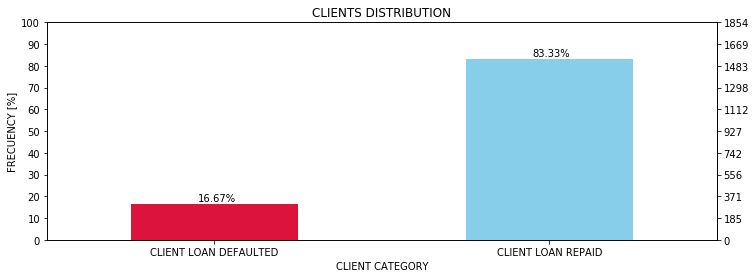

In [10]:
plt.figure(figsize=(12,4))
plt.title('CLIENTS DISTRIBUTION')
plt.xlabel('CLIENT CATEGORY')
plt.ylabel('FRECUENCY [%]')

my_colors = ['crimson','skyblue']

ax = (data.category.value_counts()/len(data)*100).sort_index().plot(kind="bar", rot=0,color=my_colors)
ax.set_yticks(np.arange(0, 110, 10))

ax2 = ax.twinx()
ax2.set_yticks(np.arange(0, 110, 10)*len(data)/100)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.20, p.get_height()+1))

### COMENTARIOS DEL DATASET:

- Las clases en el *dataset* están ordenadas. Desde el índice 0 al 1544 se hallan todos los clientes que cumplieron con la devolución total del crédito (*TARGET* = 0) y desde el índice 1545 hasta el final del *dataset*, se hallan los incumplidores (*TARGET* = 1)
- El gráfico de barras evidencia el gran **desbalance** que presenta el *dataset* entre las clases en estudio, pues un 83.3% se corresponde con información de clientes cumplidores y sólo un 16.7% a clientes incumplidores.  

A continuación se aplicará el clasificador: **Descenso de Gradiente Estocástico**, sobre todos los atributos del *dataset*, excluyendo a *TARGET*. Esto se hará considerando los datos originales y los datos normalizados al rango [0-1]. Si bien SciKitLearn posee métodos de normalización, el presente trabajo utiliza una función casera.

In [11]:
# Funcion que normaliza los features
def normalize(dataset_):
    db = dataset_.copy()
    for feature in db.columns:
        feature_min = db[feature].min()
        feature_max = db[feature].max()
        db[feature] = (db[feature]- feature_min)/(feature_max-feature_min)
    return db

In [12]:
# se normaliza separadamente la muestra de entrenamiento de la de test 
normalized_X_train = normalize(X_train)
normalized_X_test = normalize(X_test)

In [13]:
# se corrobora que min y max sean 0 y 1 respectivamente
normalized_X_train.describe()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000
mean,0.195885,0.177764,0.173785,0.216799,0.019825,0.032097,0.152979,0.085067,0.335557,0.236313
std,0.121390,0.115707,0.113182,0.183494,0.073183,0.091958,0.073245,0.126255,0.144518,0.066776
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.118048,0.109862,0.100490,0.073171,0.000000,0.000000,0.098744,0.000000,0.246154,0.200411
50%,0.172531,0.154219,0.146067,0.170732,0.000000,0.000000,0.148448,0.076923,0.323077,0.242515
75%,0.248581,0.216443,0.204483,0.317073,0.000000,0.000000,0.195993,0.153846,0.415385,0.269122
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
normalized_X_test.describe()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,0.203626,0.201562,0.179661,0.248503,0.020793,0.045052,0.281185,0.111002,0.333975,0.348983
std,0.142685,0.135946,0.131557,0.213311,0.083412,0.137767,0.133346,0.159424,0.158357,0.104961
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.111046,0.120007,0.094142,0.083333,0.000000,0.000000,0.179229,0.000000,0.222222,0.285974
50%,0.173913,0.178971,0.156264,0.194444,0.000000,0.000000,0.273525,0.090909,0.317460,0.354041
75%,0.267920,0.262022,0.225021,0.361111,0.000000,0.000000,0.370526,0.181818,0.428571,0.411717
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

*TARGET* = 0 se etiqueta como **CUMPLE**, haciendo alusión a clientes que devolverán el dinero, por el contrario *TARGET* = 1 se etiqueta como **NO CUMPLE**
 

In [74]:
labels = ['CUMPLE','NO CUMPLE']

In [88]:
# se definen los clasifidores lineales que utilizarán variables originales (clf) 
# o normalizadas (clfn)
clf = SGDClassifier(random_state=23)
clfn = SGDClassifier(random_state=23)

In [89]:
clf.fit(X_train,y_train)
clfn.fit(normalized_X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=23, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

## CLASIFICACIÓN EN BASE A DATOS SIN NORMALIZAR

MATRICES DE CONFUSIÓN - CLASIFICACIÓN SOBRE VARIABLES SIN NORMALIZAR




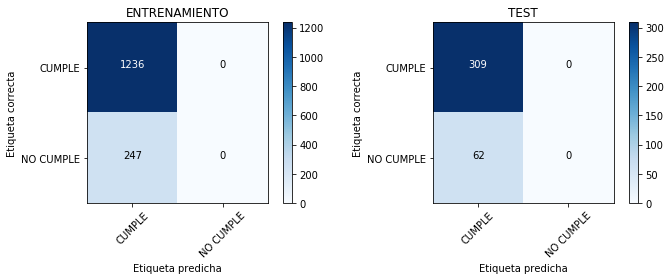

In [77]:
print('MATRICES DE CONFUSIÓN - CLASIFICACIÓN SOBRE VARIABLES SIN NORMALIZAR\n\n')

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, clf.predict(X_train)),
                      classes=labels, normalize=False,
                      title='ENTRENAMIENTO')
plt.subplot(1, 2, 2)
plot_confusion_matrix(confusion_matrix(y_test, clf.predict(X_test)),
                      classes=labels, normalize=False,
                      title='TEST')

In [78]:
print('CLASIFICACIÓN SOBRE VARIABLES SIN NORMALIZAR\n\n')

print('\t\tTRAIN\t|\t TEST')
print('--------------------------------------------')
print('Exactitud  \t%.2f \t|\t %.2f'%(accuracy_score   (y_train, clf.predict(X_train)),accuracy_score   (y_test, clf.predict(X_test))))
print('Precisión  \t%.2f \t|\t %.2f'%(precision_score  (y_train, clf.predict(X_train)),precision_score  (y_test, clf.predict(X_test))))
print('   Recall  \t%.2f \t|\t %.2f'%(recall_score     (y_train, clf.predict(X_train)),recall_score     (y_test, clf.predict(X_test))))
print('       F1  \t%.2f \t|\t %.2f'%(f1_score         (y_train, clf.predict(X_train)),f1_score         (y_test, clf.predict(X_test))))
print('      ROC  \t%.2f \t|\t %.2f'%(roc_auc_score    (y_train, clf.predict(X_train)),roc_auc_score    (y_test, clf.predict(X_test))))

CLASIFICACIÓN SOBRE VARIABLES SIN NORMALIZAR


		TRAIN	|	 TEST
--------------------------------------------
Exactitud  	0.83 	|	 0.83
Precisión  	0.00 	|	 0.00
   Recall  	0.00 	|	 0.00
       F1  	0.00 	|	 0.00
    Kappa  	0.00 	|	 0.00
      ROC  	0.50 	|	 0.50


Observando la matriz de confusión, los valores de las métricas arrojados por las funciones anteriores, no son correctos, pues:

- precision:  $\frac{True_{C}}{True_{C}+False_{C}} = 0.83$
- recall: $\frac{True_{C}}{True_{C}+False_{NC}} = 1.00$

*donde los subíndices C y NC corresponden a CUMPLE y NO CUMPLE, respectivamente*

Tales valores no coinciden con los resultados anteriores, por lo tanto se utiliza otro método de *scikit-learn* que reporta los valores de las métricas analizadas.

In [79]:
print('CLASIFICACIÓN SOBRE VARIABLES SIN NORMALIZAR\n\n')
print('REPORTE DE MÉTRICAS PARA RENDIMIENTO DEL MEJOR CLASIFICADOR ENCONTRADOD SOBRE:\n')
print('.:CONJUNTO DE ENTRENAMIENTO\n')
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred),'\n\n\n')

print('.:CONJUNTO DE TEST\n')
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred),'\n')

CLASIFICACIÓN SOBRE VARIABLES SIN NORMALIZAR


REPORTE DE MÉTRICAS PARA RENDIMIENTO DEL MEJOR CLASIFICADOR ENCONTRADOD SOBRE:

.:CONJUNTO DE ENTRENAMIENTO

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1236
           1       0.00      0.00      0.00       247

   micro avg       0.83      0.83      0.83      1483
   macro avg       0.42      0.50      0.45      1483
weighted avg       0.69      0.83      0.76      1483
 



.:CONJUNTO DE TEST

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       309
           1       0.00      0.00      0.00        62

   micro avg       0.83      0.83      0.83       371
   macro avg       0.42      0.50      0.45       371
weighted avg       0.69      0.83      0.76       371
 



### RESULTADOS:

Se observa que la exactitud es similar al porcentaje de clientes cumplidores que posee el *dataset*, lo cual resulta trivial pues, en este caso, el clasificador está determinando que todos los clientes son cumplidores. A su vez, las otras métricas no agregan valor sobre la decisión de considerar o no el modelo, pues otorgan mejores resultados que conllevarían a considerar al modelo como bueno. Lo importante es **REMARCAR** que se desea encontrar a clientes no cumplidores, por lo tanto, que el clasificador tenga una *performance* de 80-90-100 % sobre los clientes cumplidores, no aporta nada al objetivo.




## CLASIFICACIÓN EN BASE A DATOS NORMALIZADOS

MATRICES DE CONFUSIÓN - CLASIFICACIÓN SOBRE VARIABLES NORMALIZADAS




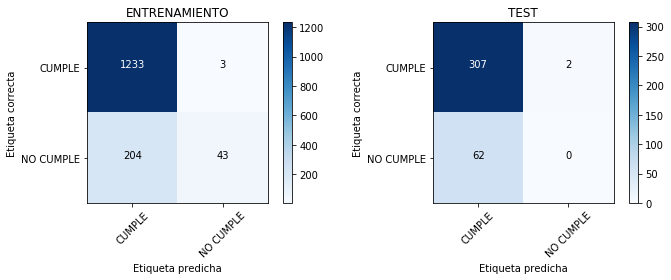

In [90]:
print('MATRICES DE CONFUSIÓN - CLASIFICACIÓN SOBRE VARIABLES NORMALIZADAS\n\n')

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, clfn.predict(normalized_X_train)),
                      classes=labels, normalize=False,
                      title='ENTRENAMIENTO')
plt.subplot(1, 2, 2)
plot_confusion_matrix(confusion_matrix(y_test, clf.predict(normalized_X_test)),
                      classes=labels, normalize=False,
                      title='TEST')

In [91]:
print('CLASIFICACIÓN SOBRE VARIABLES NORMALIZADAS\n\n')

print('\t\tTRAIN\t|\t TEST')
print('--------------------------------------------')
print('Exactitud  \t%.2f \t|\t %.2f'%(accuracy_score   (y_train, clfn.predict(normalized_X_train)),accuracy_score   (y_test, clfn.predict(normalized_X_test))))
print('Precisión  \t%.2f \t|\t %.2f'%(precision_score  (y_train, clfn.predict(normalized_X_train)),precision_score  (y_test, clfn.predict(normalized_X_test))))
print('   Recall  \t%.2f \t|\t %.2f'%(recall_score     (y_train, clfn.predict(normalized_X_train)),recall_score     (y_test, clfn.predict(normalized_X_test))))
print('       F1  \t%.2f \t|\t %.2f'%(f1_score         (y_train, clfn.predict(normalized_X_train)),f1_score         (y_test, clfn.predict(normalized_X_test))))
print('      ROC  \t%.2f \t|\t %.2f'%(roc_auc_score    (y_train, clfn.predict(normalized_X_train)),roc_auc_score    (y_test, clfn.predict(normalized_X_test))))

CLASIFICACIÓN SOBRE VARIABLES NORMALIZADAS


		TRAIN	|	 TEST
--------------------------------------------
Exactitud  	0.86 	|	 0.87
Precisión  	0.93 	|	 0.69
   Recall  	0.17 	|	 0.39
       F1  	0.29 	|	 0.49
      ROC  	0.59 	|	 0.68


In [82]:
print('CLASIFICACIÓN SOBRE VARIABLES NORMALIZADAS\n\n')
print('REPORTE DE METRICAS PARA RENDIMIENTO DEL MEJOR CLASIFICADOR ENCONTRADOD SOBRE:\n')
print('.:CONJUNTO DE ENTRENAMIENTO\n')
y_true, y_pred = y_train, clfn.predict(normalized_X_train)
print(classification_report(y_true, y_pred),'\n\n\n')

print('.:CONJUNTO DE TEST\n')
y_true, y_pred = y_test, clfn.predict(normalized_X_test)
print(classification_report(y_true, y_pred),'\n')

CLASIFICACIÓN SOBRE VARIABLES NORMALIZADAS


REPORTE DE METRICAS PARA RENDIMIENTO DEL MEJOR CLASIFICADOR ENCONTRADOD SOBRE:

.:CONJUNTO DE ENTRENAMIENTO

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1236
           1       0.93      0.17      0.29       247

   micro avg       0.86      0.86      0.86      1483
   macro avg       0.90      0.59      0.61      1483
weighted avg       0.87      0.86      0.82      1483
 



.:CONJUNTO DE TEST

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       309
           1       0.69      0.39      0.49        62

   micro avg       0.87      0.87      0.87       371
   macro avg       0.79      0.68      0.71       371
weighted avg       0.85      0.87      0.85       371
 



### RESULTADOS:

Se observa que el simple hecho de haber considerado datos normalizados mejora en mucho las predicciones, pues por un lado, no clasifica a todos los casos como buenos clientes sobre el conjunto de entrenamiento, si bien solo acierta un 17% de los casos no cumplidores, por lo menos se descartarán algunos, lo cual es mejor que no descartar nada. De todos modos, al ver los resultados sobre el conjunto de test, se observa que los pocos casos predichos como incumplidores, son incorrectos.

Por lo tanto, se concluye que, aunque la normalización permite eficientizar al modelo, sigue siendo un resultado pobre. A continuación se generarán muchos modelos en base a combinaciones entre funciones de costo, tasas de entrenamiento y regularización, con el fin de explorar cómo los hiperparámetros del clasificador pueden mejorar la *performance* del mismo. Todos los modelos se entrenarán y validarán sobre datos normalizados  

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [95]:
loss_function = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
metrics = ['accuracy','precision','recall','f1','roc_auc']

---------------------------------------------------------------------------
---------------------------------------------------------------------------
                            MÉTRICA: ACCURACY
---------------------------------------------------------------------------
---------------------------------------------------------------------------


*********************************
*    FUNCIÓN DE COSTE: HINGE    *
*********************************


.:EXPLORACIÓN DE HIPERPARÁMETROS PARA "HINGE"


..:Mejor conjunto de parámetros:
       {'alpha': 0.0001, 'eta0': 0.21544346900318845, 'learning_rate': 'constant'}


..:Puntajes de la grilla a medida que mejora accuracy o varianza:

       Exactitud: 0.833 (+/-0.000002) para los parámetros {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}
       Exactitud: 0.833 (+/-0.000002) para los parámetros {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}
       Exactitud: 0.856 (+/-0.000034) para los parámetros {'alpha': 0

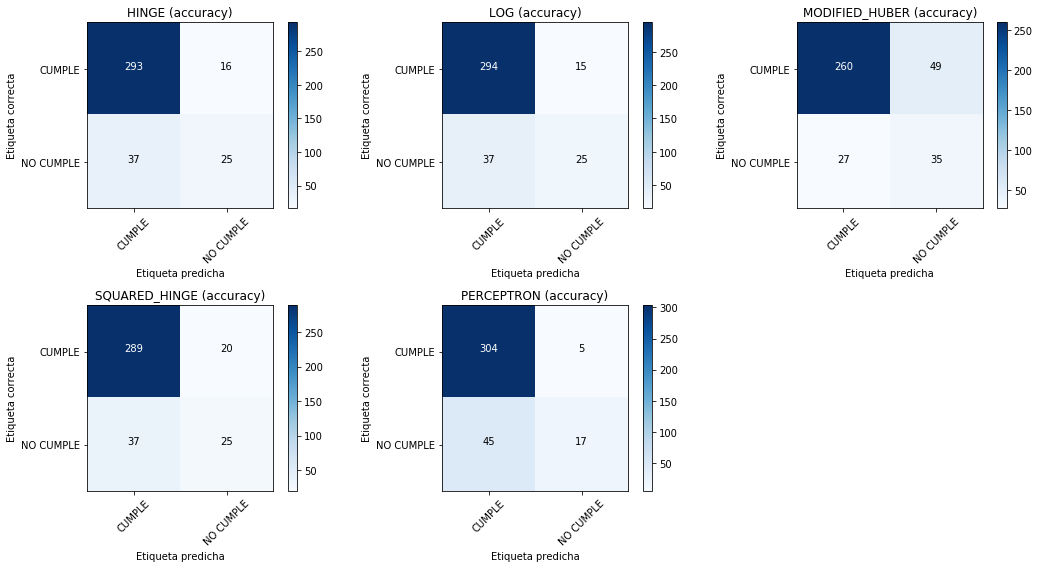





---------------------------------------------------------------------------
---------------------------------------------------------------------------
                            MÉTRICA: PRECISION
---------------------------------------------------------------------------
---------------------------------------------------------------------------


*********************************
*    FUNCIÓN DE COSTE: HINGE    *
*********************************


.:EXPLORACIÓN DE HIPERPARÁMETROS PARA "HINGE"


..:Mejor conjunto de parámetros:
       {'alpha': 0.00035938136638046257, 'eta0': 0.016681005372000592, 'learning_rate': 'constant'}


..:Puntajes de la grilla a medida que mejora precision o varianza:

       Exactitud: 0.000 (+/-0.000000) para los parámetros {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}
       Exactitud: 0.978 (+/-0.001982) para los parámetros {'alpha': 0.0001, 'eta0': 0.016681005372000592, 'learning_rate': 'constant'}
       Exactitud: 1.000 (+/-0.00

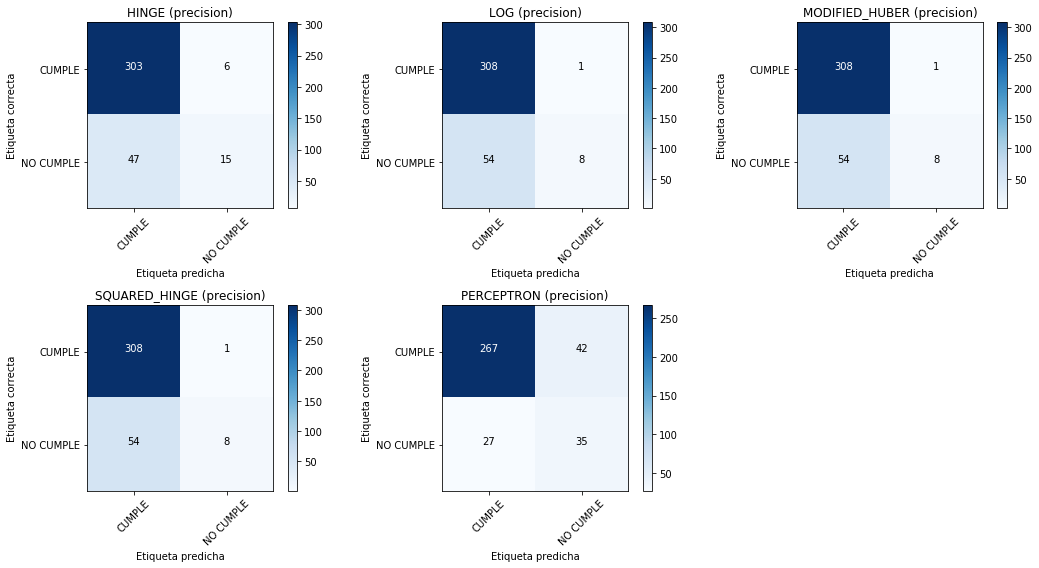





---------------------------------------------------------------------------
---------------------------------------------------------------------------
                            MÉTRICA: RECALL
---------------------------------------------------------------------------
---------------------------------------------------------------------------


*********************************
*    FUNCIÓN DE COSTE: HINGE    *
*********************************


.:EXPLORACIÓN DE HIPERPARÁMETROS PARA "HINGE"


..:Mejor conjunto de parámetros:
       {'alpha': 0.05994842503189409, 'eta0': 2.782559402207126, 'learning_rate': 'constant'}


..:Puntajes de la grilla a medida que mejora recall o varianza:

       Exactitud: 0.000 (+/-0.000000) para los parámetros {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}
       Exactitud: 0.138 (+/-0.001503) para los parámetros {'alpha': 0.0001, 'eta0': 0.016681005372000592, 'learning_rate': 'constant'}
       Exactitud: 0.194 (+/-0.002281) para l

**************************************
*    FUNCIÓN DE COSTE: PERCEPTRON    *
**************************************


.:EXPLORACIÓN DE HIPERPARÁMETROS PARA "PERCEPTRON"


..:Mejor conjunto de parámetros:
       {'alpha': 0.001291549665014884, 'eta0': 0.21544346900318845, 'learning_rate': 'constant'}


..:Puntajes de la grilla a medida que mejora recall o varianza:

       Exactitud: 0.335 (+/-0.024064) para los parámetros {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}
       Exactitud: 0.335 (+/-0.024064) para los parámetros {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}
       Exactitud: 0.359 (+/-0.020385) para los parámetros {'alpha': 0.0001, 'eta0': 0.004641588833612782, 'learning_rate': 'constant'}
       Exactitud: 0.359 (+/-0.020385) para los parámetros {'alpha': 0.0001, 'eta0': 0.004641588833612782, 'learning_rate': 'constant'}
       Exactitud: 0.324 (+/-0.015836) para los parámetros {'alpha': 0.0001, 'eta0': 0.21544346900318845, 'learning_rate

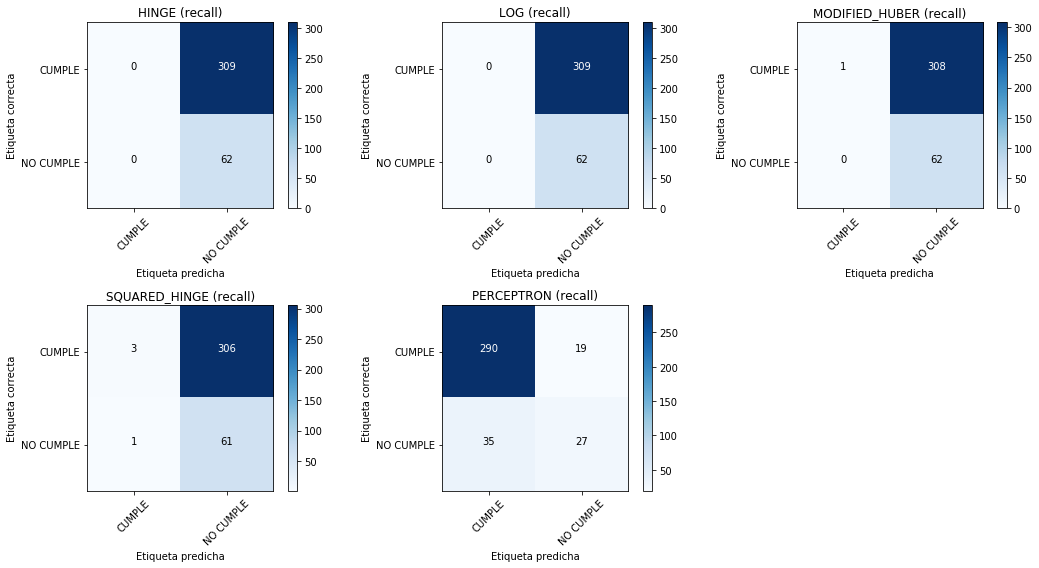





---------------------------------------------------------------------------
---------------------------------------------------------------------------
                            MÉTRICA: F1
---------------------------------------------------------------------------
---------------------------------------------------------------------------


*********************************
*    FUNCIÓN DE COSTE: HINGE    *
*********************************


.:EXPLORACIÓN DE HIPERPARÁMETROS PARA "HINGE"


..:Mejor conjunto de parámetros:
       {'alpha': 0.00035938136638046257, 'eta0': 0.7742636826811278, 'learning_rate': 'constant'}


..:Puntajes de la grilla a medida que mejora f1 o varianza:

       Exactitud: 0.000 (+/-0.000000) para los parámetros {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}
       Exactitud: 0.239 (+/-0.003622) para los parámetros {'alpha': 0.0001, 'eta0': 0.016681005372000592, 'learning_rate': 'constant'}
       Exactitud: 0.317 (+/-0.003313) para los p

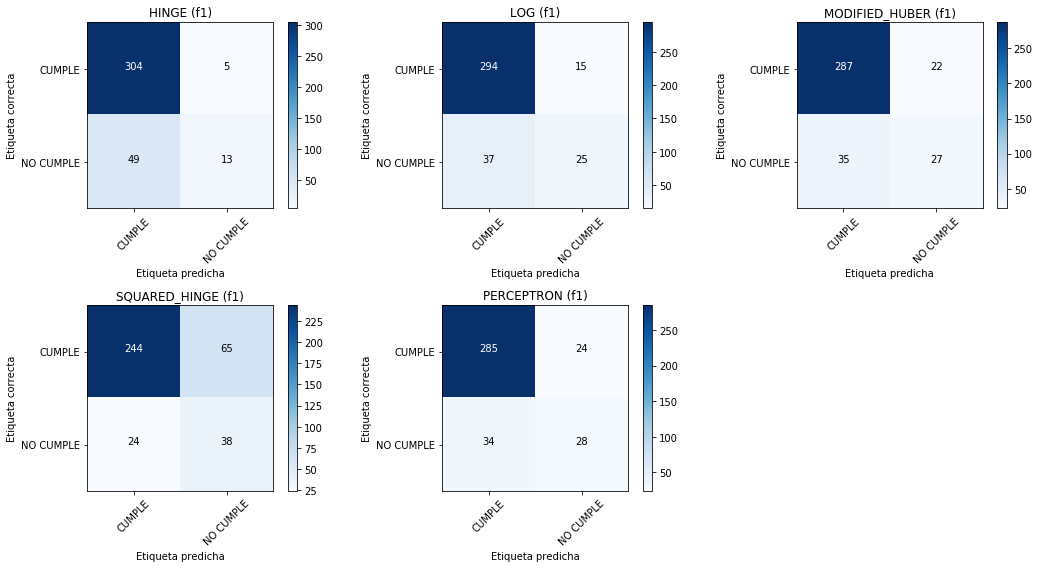





---------------------------------------------------------------------------
---------------------------------------------------------------------------
                            MÉTRICA: ROC_AUC
---------------------------------------------------------------------------
---------------------------------------------------------------------------


*********************************
*    FUNCIÓN DE COSTE: HINGE    *
*********************************


.:EXPLORACIÓN DE HIPERPARÁMETROS PARA "HINGE"


..:Mejor conjunto de parámetros:
       {'alpha': 0.001291549665014884, 'eta0': 0.004641588833612782, 'learning_rate': 'constant'}


..:Puntajes de la grilla a medida que mejora roc_auc o varianza:

       Exactitud: 0.525 (+/-0.002774) para los parámetros {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}
       Exactitud: 0.525 (+/-0.002774) para los parámetros {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}
       Exactitud: 0.546 (+/-0.002607) para los parám

**************************************
*    FUNCIÓN DE COSTE: PERCEPTRON    *
**************************************


.:EXPLORACIÓN DE HIPERPARÁMETROS PARA "PERCEPTRON"


..:Mejor conjunto de parámetros:
       {'alpha': 0.0001, 'eta0': 2.782559402207126, 'learning_rate': 'constant'}


..:Puntajes de la grilla a medida que mejora roc_auc o varianza:

       Exactitud: 0.772 (+/-0.001752) para los parámetros {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}
       Exactitud: 0.772 (+/-0.001752) para los parámetros {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}
       Exactitud: 0.774 (+/-0.001518) para los parámetros {'alpha': 0.0001, 'eta0': 0.001291549665014884, 'learning_rate': 'constant'}
       Exactitud: 0.774 (+/-0.001518) para los parámetros {'alpha': 0.0001, 'eta0': 0.001291549665014884, 'learning_rate': 'constant'}
       Exactitud: 0.775 (+/-0.001287) para los parámetros {'alpha': 0.0001, 'eta0': 0.004641588833612782, 'learning_rate': 'constant'}

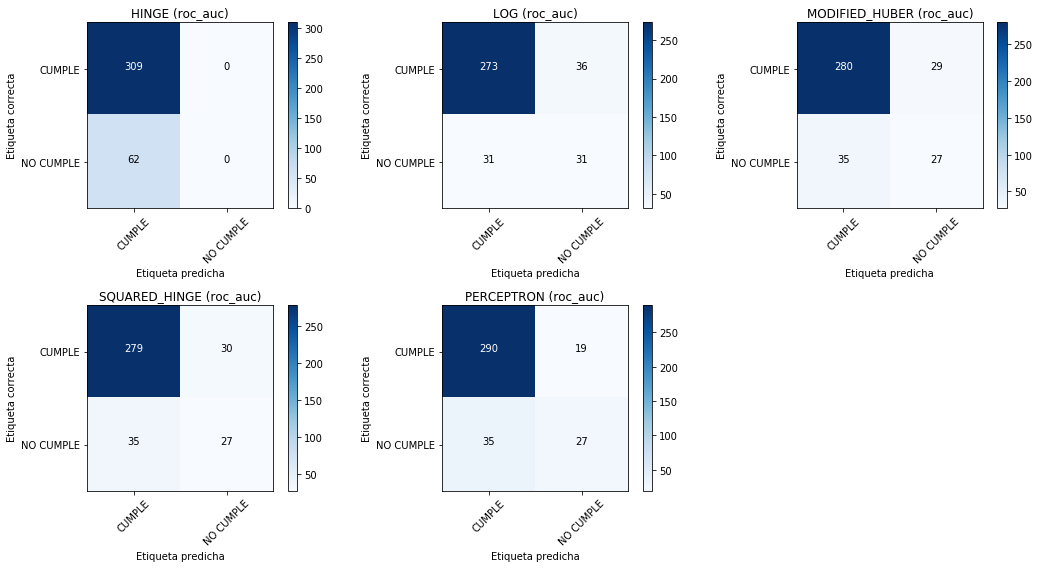

In [25]:
n = 10
alphas= np.logspace(-4, 1, n)
etas= np.logspace(-4, 1, n)

exploring_params =  {'learning_rate': ['constant'],
                     'eta0': etas, 
                     'alpha': alphas  # Tasa de regularización
                    }


for metrica in metrics:
    print('---------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------')
    print('                            MÉTRICA: '+metrica.upper())
    print('---------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------',end='\n\n\n')

    plt.figure(figsize=(15,8))
    for idx, loss in enumerate(loss_function, start=1):
        clfn = SGDClassifier(loss=loss, tol=1e-3, random_state=23)
        model = GridSearchCV(clfn, exploring_params, cv=5, scoring=metrica)
        model.fit(normalized_X_train, y_train)
        print('*****'+'*'*len('FUNCIÓN DE COSTE :'+loss.upper())+'*****')
        print('*    FUNCIÓN DE COSTE: '+loss.upper()+'    *')
        print('*****'+'*'*len('FUNCIÓN DE COSTE :'+loss.upper())+'*****', end="\n\n\n")
        
        print(".:EXPLORACIÓN DE HIPERPARÁMETROS PARA \"%s\"" % loss.upper(), end="\n\n\n")
        
        print("..:Mejor conjunto de parámetros:")
        print("      ",model.best_params_, end="\n\n\n")
    
        print('..:Puntajes de la grilla a medida que mejora '+metrica+' o varianza:', end="\n\n")
        means = model.cv_results_['mean_test_score']
        stds = model.cv_results_['std_test_score']
        
        scoremax=0 
        stdmin=1
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            if std<stdmin: 
                stdmin=std
                print("       Exactitud: %0.3f (+/-%0.06f) para los parámetros %r" % (mean, std ** 2, params))
            if mean>scoremax:
                scoremax=mean
                print("       Exactitud: %0.3f (+/-%0.06f) para los parámetros %r" % (mean, std ** 2, params))
        print("\n")
    
        print("..:Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
        y_true, y_pred = y_test, model.predict(normalized_X_test)
        print(classification_report(y_true, y_pred), end="\n\n\n\n")
        
    
        plt.subplot(2, 3, idx)
        plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                              classes=labels, title=loss.upper()+' ('+metrica+')')
    plt.savefig(metrica+'.pdf')
    plt.show()
    print('\n\n\n')
     

### OBSERVACIÓN:
La mejor combinación de hiperparámetros, es decir, aquella que maximiza el valor de la métrica en estudio, no necesariamente se condice con la combinación de menor varianza.

In [146]:
lista = []

lista.append({'metrica':'accuracy' ,'hinge':41 , 'log':40 , 'modified_huber':84 , 'squared_hinge':45 , 'perceptron':21}, )
lista.append({'metrica':'precision','hinge':21 , 'log':9  , 'modified_huber':9  , 'squared_hinge':9  , 'perceptron':77})
lista.append({'metrica':'recall'   ,'hinge':371, 'log':371, 'modified_huber':370, 'squared_hinge':364, 'perceptron':46})
lista.append({'metrica':'F1'       ,'hinge':18 , 'log':40 , 'modified_huber':49 , 'squared_hinge':103, 'perceptron':52})
lista.append({'metrica':'roc-auc'  ,'hinge':0  , 'log':67 , 'modified_huber':56 , 'squared_hinge':57 , 'perceptron':46})

resultados = pd.DataFrame(lista)
resultados = resultados.set_index('metrica')


In [147]:
resultados = round(resultados/len(y_test[y_test.values==1]),2)

In [148]:
resultados

,hinge,log,modified_huber,perceptron,squared_hinge
metrica,,,,,
accuracy,0.66,0.65,1.35,0.34,0.73
precision,0.34,0.15,0.15,1.24,0.15
recall,5.98,5.98,5.97,0.74,5.87
F1,0.29,0.65,0.79,0.84,1.66
roc-auc,0.00,1.08,0.90,0.74,0.92


### RESULTADOS:

Teniendo en cuenta que el conjunto de test contiene 62 muestras, lo que se busca es que el modelo bien, o no tan bien, elimine (cliente rechazado) lo más cercano a 62 muestras, siempre y cuando, la precisión de esta etiqueta no esté por debajo del 50%. Como siempre hay una decisión de compromiso entre qué tantos incumplidores sobreviven y qué tantos cumplidores se rechaza. En este caso, se toma el siguiente criterio considerando la salvedad anterior:

$$1 \sim \frac{True_{NC}+False_{NC}}{True_{NC}+False_C}$$

En base a ello se obtiene que el modelo que combina la función de costo: *log* con la métrica: *roc-auc*, es el que otorga la mejor *performance* de clasificación. Si bien no es la combinación que entrega los valores más altos de exactitud y precisión, es la que se adapta al criterio escogido.



## Ejercicio 3: Árbol de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [149]:
clf = DecisionTreeClassifier(random_state=23)
clf = clf.fit(X_train, y_train)

clfn = DecisionTreeClassifier(random_state=23)
clfn = clf.fit(normalized_X_train, y_train)

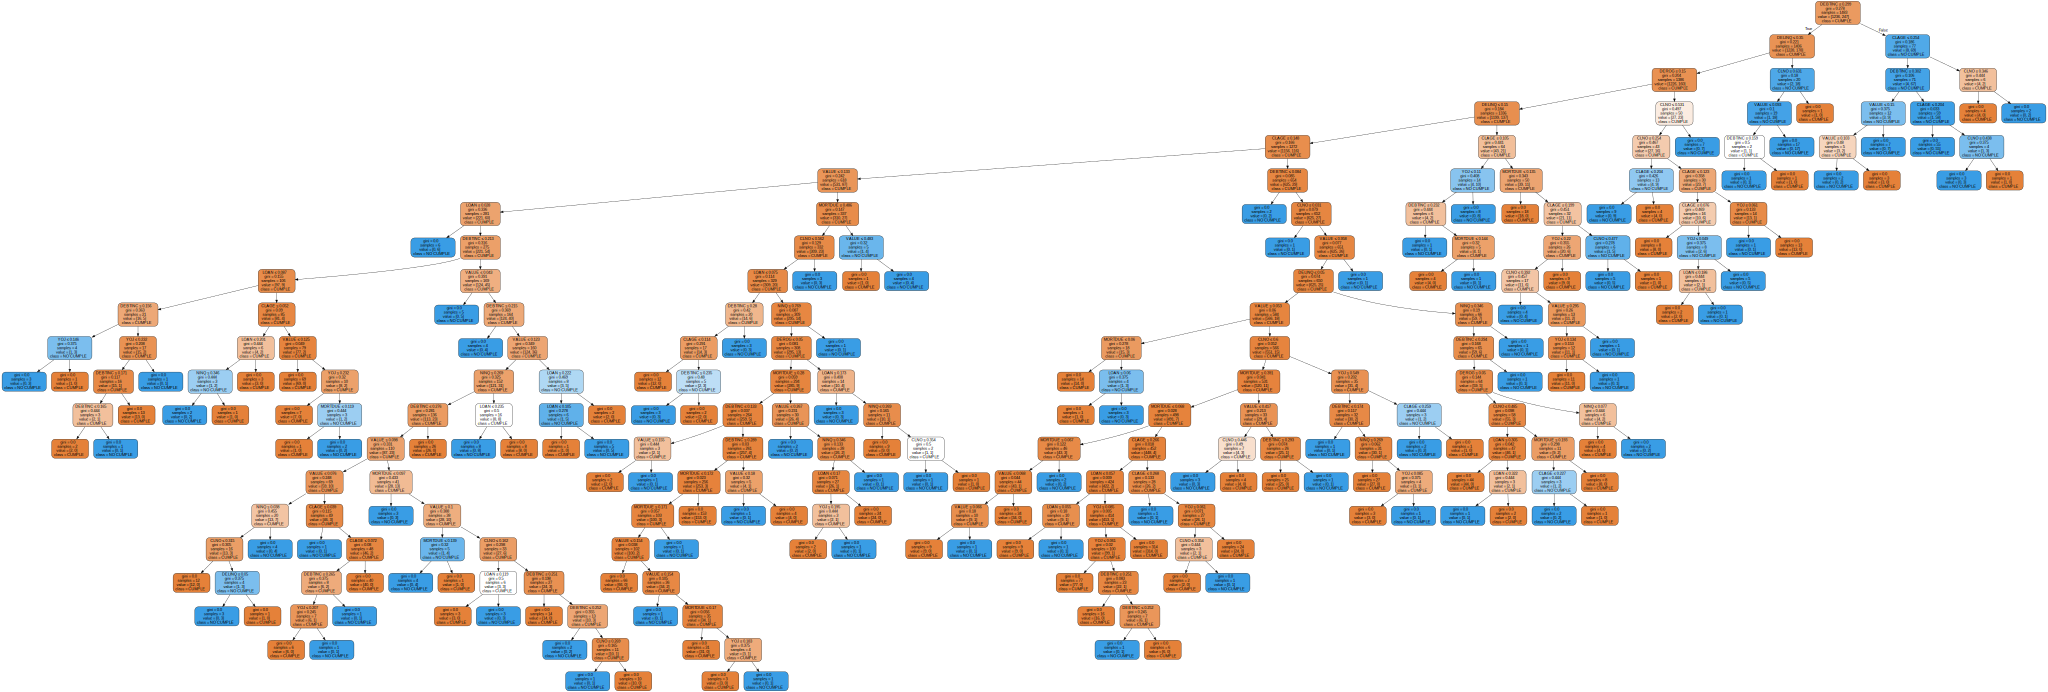

In [47]:
#dot_data = export_graphviz(clf, out_file=None, 
#                         feature_names=X_train.columns,  
#                         class_names=labels,  
#                         filled=True, rounded=True,  
#                         special_characters=True)

#graph = graphviz.Source(dot_data)

#graph

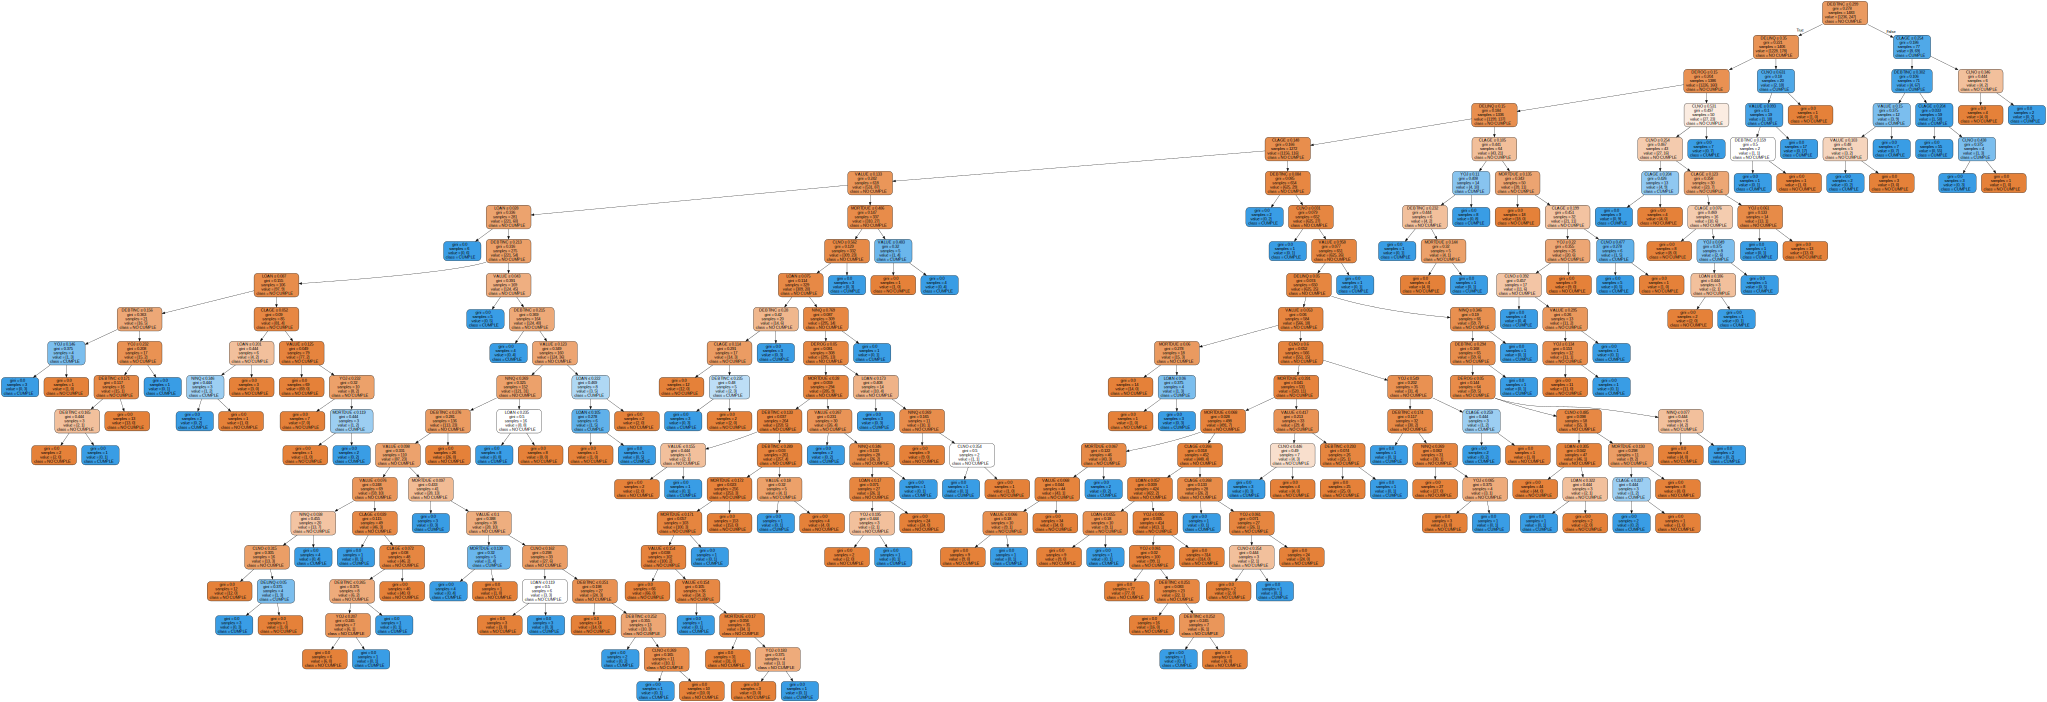

In [38]:
#dot_data = export_graphviz(clfn, out_file=None, 
#                         feature_names=normalized_X_train.columns,  
#                         class_names=labels,  
#                         filled=True, rounded=True,  
#                         special_characters=True)

#graph = graphviz.Source(dot_data)

#graph

MATRICES DE CONFUSIÓN


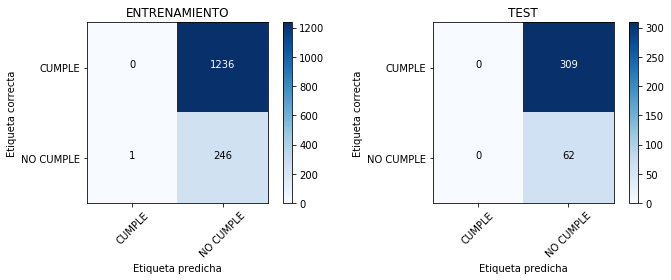

In [150]:
print('MATRICES DE CONFUSIÓN')

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, clf.predict(X_train)),
                      classes=labels, normalize=False,
                      title='ENTRENAMIENTO')
plt.subplot(1, 2, 2)
plot_confusion_matrix(confusion_matrix(y_test, clf.predict(X_test)),
                      classes=labels, normalize=False,
                      title='TEST')

In [151]:
print('\t\tTRAIN\t|\t TEST')
print('--------------------------------------------')
print('Exactitud  \t%.2f \t|\t %.2f'%(accuracy_score   (y_train, clf.predict(X_train)),accuracy_score   (y_test, clf.predict(X_test))))
print('Precisión  \t%.2f \t|\t %.2f'%(precision_score  (y_train, clf.predict(X_train)),precision_score  (y_test, clf.predict(X_test))))
print('   Recall  \t%.2f \t|\t %.2f'%(recall_score     (y_train, clf.predict(X_train)),recall_score     (y_test, clf.predict(X_test))))
print('       F1  \t%.2f \t|\t %.2f'%(f1_score         (y_train, clf.predict(X_train)),f1_score         (y_test, clf.predict(X_test))))
print('    Kappa  \t%.2f \t|\t %.2f'%(cohen_kappa_score(y_train, clf.predict(X_train)),cohen_kappa_score(y_test, clf.predict(X_test))))
print('      ROC  \t%.2f \t|\t %.2f'%(roc_auc_score    (y_train, clf.predict(X_train)),roc_auc_score    (y_test, clf.predict(X_test))))

		TRAIN	|	 TEST
--------------------------------------------
Exactitud  	0.17 	|	 0.17
Precisión  	0.17 	|	 0.17
   Recall  	1.00 	|	 1.00
       F1  	0.28 	|	 0.29
    Kappa  	-0.00 	|	 0.00
      ROC  	0.50 	|	 0.50


In [152]:
print('REPORTE DE METRICAS PARA RENDIMIENTO DEL MEJOR CLASIFICADOR ENCONTRADOD SOBRE:\n')
print('.:CONJUNTO DE ENTRENAMIENTO\n')
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred),'\n\n\n')

print('.:CONJUNTO DE TEST\n')
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred),'\n')

REPORTE DE METRICAS PARA RENDIMIENTO DEL MEJOR CLASIFICADOR ENCONTRADOD SOBRE:

.:CONJUNTO DE ENTRENAMIENTO

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1236
           1       0.17      1.00      0.28       247

   micro avg       0.17      0.17      0.17      1483
   macro avg       0.08      0.50      0.14      1483
weighted avg       0.03      0.17      0.05      1483
 



.:CONJUNTO DE TEST

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       309
           1       0.17      1.00      0.29        62

   micro avg       0.17      0.17      0.17       371
   macro avg       0.08      0.50      0.14       371
weighted avg       0.03      0.17      0.05       371
 



MATRICES DE CONFUSIÓN


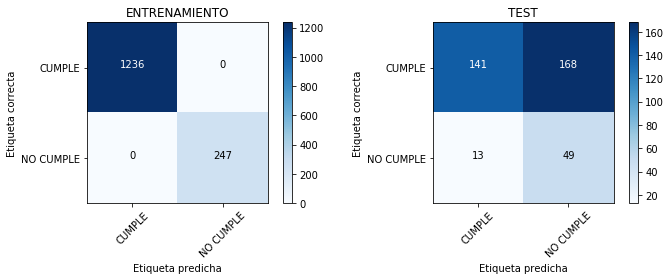

In [153]:
print('MATRICES DE CONFUSIÓN')

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, clfn.predict(normalized_X_train)),
                      classes=labels, normalize=False,
                      title='ENTRENAMIENTO')
plt.subplot(1, 2, 2)
plot_confusion_matrix(confusion_matrix(y_test, clfn.predict(normalized_X_test)),
                      classes=labels, normalize=False,
                      title='TEST')

In [154]:
print('\t\tTRAIN\t|\t TEST')
print('--------------------------------------------')
print('Exactitud  \t%.2f \t|\t %.2f'%(accuracy_score   (y_train, clfn.predict(normalized_X_train)),accuracy_score   (y_test, clfn.predict(normalized_X_test))))
print('Precisión  \t%.2f \t|\t %.2f'%(precision_score  (y_train, clfn.predict(normalized_X_train)),precision_score  (y_test, clfn.predict(normalized_X_test))))
print('   Recall  \t%.2f \t|\t %.2f'%(recall_score     (y_train, clfn.predict(normalized_X_train)),recall_score     (y_test, clfn.predict(normalized_X_test))))
print('       F1  \t%.2f \t|\t %.2f'%(f1_score         (y_train, clfn.predict(normalized_X_train)),f1_score         (y_test, clfn.predict(normalized_X_test))))
print('    Kappa  \t%.2f \t|\t %.2f'%(cohen_kappa_score(y_train, clfn.predict(normalized_X_train)),cohen_kappa_score(y_test, clfn.predict(normalized_X_test))))
print('      ROC  \t%.2f \t|\t %.2f'%(roc_auc_score    (y_train, clfn.predict(normalized_X_train)),roc_auc_score    (y_test, clfn.predict(normalized_X_test))))

		TRAIN	|	 TEST
--------------------------------------------
Exactitud  	1.00 	|	 0.51
Precisión  	1.00 	|	 0.23
   Recall  	1.00 	|	 0.79
       F1  	1.00 	|	 0.35
    Kappa  	1.00 	|	 0.12
      ROC  	1.00 	|	 0.62


In [155]:
print('REPORTE DE METRICAS PARA RENDIMIENTO DEL MEJOR CLASIFICADOR ENCONTRADOD SOBRE:\n')
print('.:CONJUNTO DE ENTRENAMIENTO\n')
y_true, y_pred = y_train, clfn.predict(normalized_X_train)
print(classification_report(y_true, y_pred),'\n\n\n')

print('.:CONJUNTO DE TEST\n')
y_true, y_pred = y_test, clfn.predict(normalized_X_test)
print(classification_report(y_true, y_pred),'\n')

REPORTE DE METRICAS PARA RENDIMIENTO DEL MEJOR CLASIFICADOR ENCONTRADOD SOBRE:

.:CONJUNTO DE ENTRENAMIENTO

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1236
           1       1.00      1.00      1.00       247

   micro avg       1.00      1.00      1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483
 



.:CONJUNTO DE TEST

              precision    recall  f1-score   support

           0       0.92      0.46      0.61       309
           1       0.23      0.79      0.35        62

   micro avg       0.51      0.51      0.51       371
   macro avg       0.57      0.62      0.48       371
weighted avg       0.80      0.51      0.57       371
 



### RESULTADOS:

Nuevamente se observa lo mal que funciona el clasificador para variables sin normalizar. Por otro lado, existe una sobrepredicción de clientes incumplidores, más de la mitad terminan siendo eliminados de la lista de solicitantes en base a las predicciones que este otorga. 

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

---------------------------------------------------------------------------
---------------------------------------------------------------------------
                            MÉTRICA: ACCURACY
---------------------------------------------------------------------------
---------------------------------------------------------------------------


.:EXPLORACIÓN DE HIPERPARÁMETROS
..:Mejor conjunto de parámetros:
       {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 3}


..:Puntajes de la grilla a medida que mejora accuracy o varianza:

       Exactitud: 0.876 (+/-0.000155) para los parámetros {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
       Exactitud: 0.876 (+/-0.000155) para los parámetros {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
       Exactitud: 0.875 (+/-0.000149) para los parámetros {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_sp

.:EXPLORACIÓN DE HIPERPARÁMETROS
..:Mejor conjunto de parámetros:
       {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 5}


..:Puntajes de la grilla a medida que mejora f1 o varianza:

       Exactitud: 0.422 (+/-0.010759) para los parámetros {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
       Exactitud: 0.422 (+/-0.010759) para los parámetros {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
       Exactitud: 0.417 (+/-0.010331) para los parámetros {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2}
       Exactitud: 0.424 (+/-0.011233) para los parámetros {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 2}
       Exactitud: 0.481 (+/-0.009257) para los parámetros {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
       Exactitud: 0.481 (+/-0.009257) para los parámetros {'cri

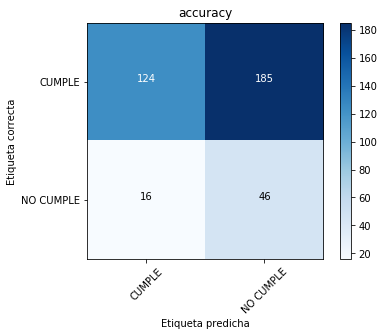

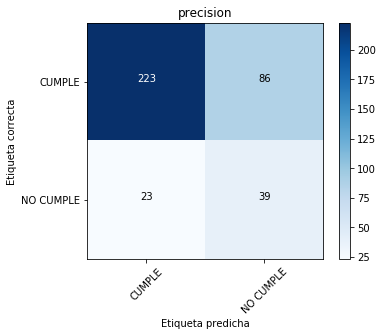

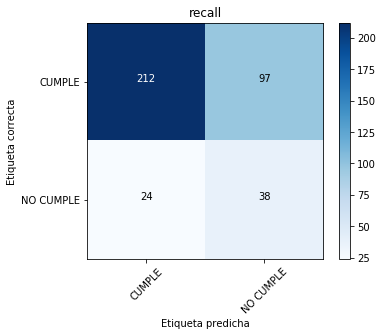

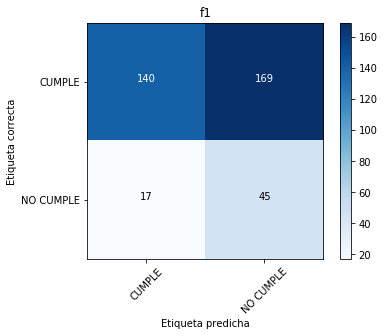

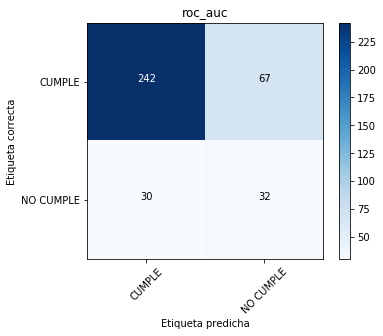

In [158]:
criterions = ['gini','entropy']
max_depths = [2,3,5,6,10,12]
min_samples_leafs = [1,2,3,4,5,8,10]
min_samples_splits = [2,3,4,5,8,10,50]


exploring_params = {'criterion':criterions,
                    'max_depth':max_depths,
                    'min_samples_leaf':min_samples_leafs,
                    'min_samples_split':min_samples_splits
                    }
j=1
for metrica in metrics:
    print('---------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------')
    print('                            MÉTRICA: '+metrica.upper())
    print('---------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------',end='\n\n\n')

    plt.figure(figsize=(15,8))
    
    clfn = DecisionTreeClassifier(random_state=23)
    model = GridSearchCV(clfn, exploring_params, cv=5, scoring=metrica)
    model.fit(normalized_X_train, y_train)
    
    print(".:EXPLORACIÓN DE HIPERPARÁMETROS")
    
    print("..:Mejor conjunto de parámetros:")
    print("      ",model.best_params_, end="\n\n\n")
    
    print('..:Puntajes de la grilla a medida que mejora '+metrica+' o varianza:', end="\n\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    
    scoremax=0 
    stdmin=1
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        if std<stdmin: 
            stdmin=std
            print("       Exactitud: %0.3f (+/-%0.06f) para los parámetros %r" % (mean, std ** 2, params))
        if mean>scoremax:
            scoremax=mean
            print("       Exactitud: %0.3f (+/-%0.06f) para los parámetros %r" % (mean, std ** 2, params))
    print("\n")
    
    print("..:Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(normalized_X_test)
    print(classification_report(y_true, y_pred), end="\n\n\n\n")
    
    
    plt.subplot(2, 3, j)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                              classes=labels, title= metrica)
    #plt.savefig(metrica+'_dtree.pdf')
    
    print('\n\n\n')
    j+=1
plt.show()    

### RESULTADOS:

La mayoría de las combinaciones para el árbol de decisión, considera un número de capas que excede el total de *features* y utiliza como criterio el coeficiente de *gini*.
Todos los modelos resultan en una sobrepredicción del número de clientes incumplidores, que va desde 99, cuando la métrica es *roc-auc*, hasta 231 bajo *accuracy*.




## CONCLUSIÓN:

En base a los distintos clasificadores utilizados y la exploración de hiperparámetros llevada a cabo, se considera que el mejor modelo consiste en utilizar un clasificador SDG, con función de costo: *log* (logarítmica) bajo la métrica *roc-auc* (área bajo la curva característica operativa del receptor) e hiperparámetros: $\alpha=1x10^{-3}$, $\eta_{0} = 0.2$ y $\eta = cte$

De todos modos se podrían haber cosniderado tasas de aprendizaje variables para analizar su impacto